In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

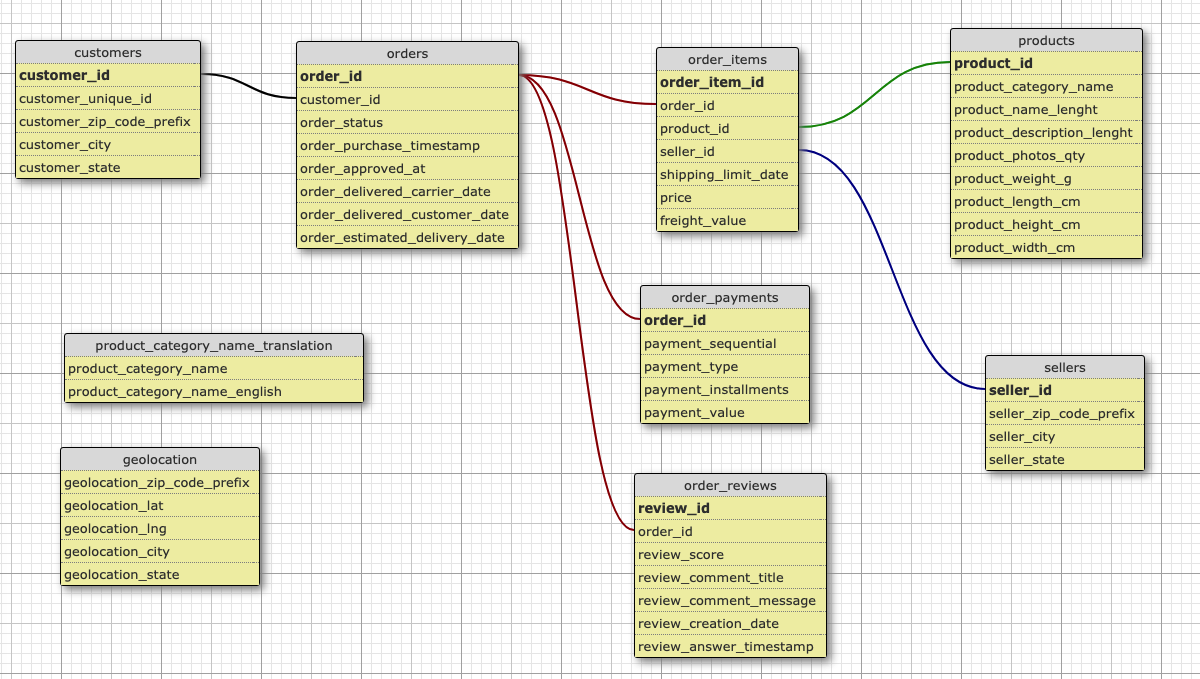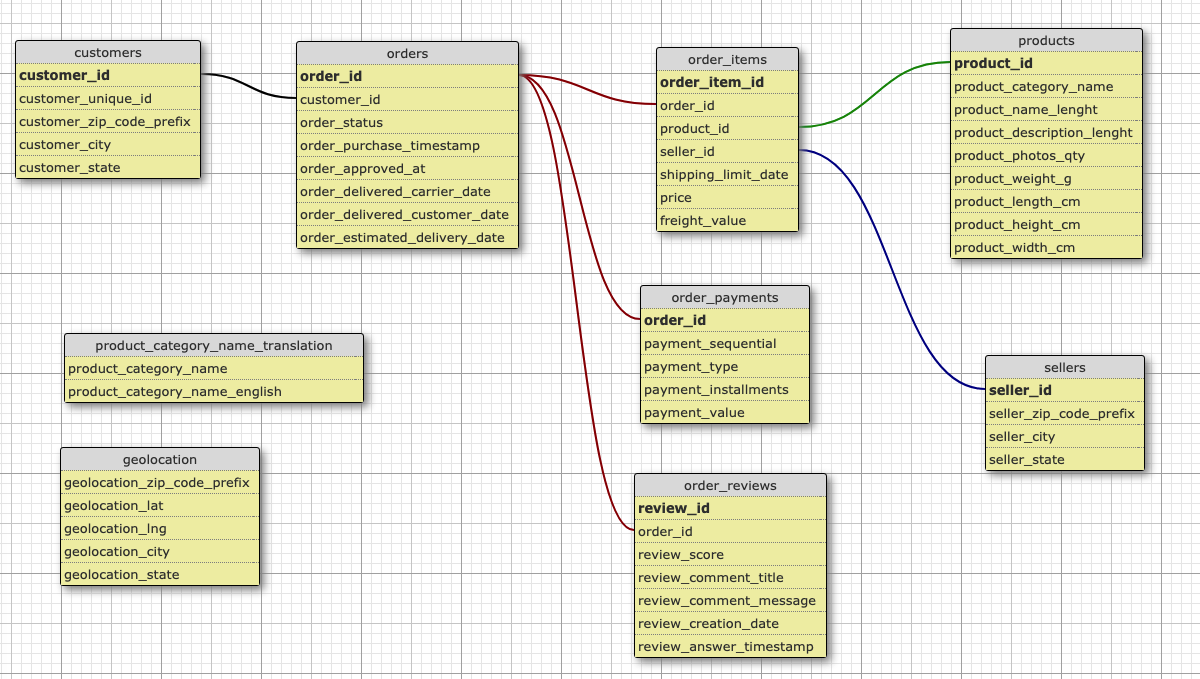

# Sellers

Our goal is to find Sellers that repeatedly underperform vs others, and understand why.  
This will help us shape our recommendations on how to improve Olist's profit margin

<details>
    <summary>🔥 Notebook best practices (reminder) </summary>

From now on, exploratory notebooks are going to get pretty long, and we strongly advise you to follow these notebook principles
- Code your logic so that your Notebook can always be run from top to bottom without crashing (Cell --> Run All)
- Name your variables carefully 
- Use dummy names such as `tmp` for intermediary steps when you know you won't need them long
- Clear your code and merge cells when relevant to minimize Notebook size (`Shift-M`)
- Hide your cell output if you don't need to see it anymore (double click on the red `Out[]:` section to the left of your cell).
- Make heavy use of jupyter nbextention `Collapsable Headings` and `Table of Content` (call a TA if you can't find them)
- Use the following shortcuts 
    - `a` to insert a cell above
    - `b` to insert a cell below
    - `dd` to delete a cell
    - `esc` and `arrows` to move between cells
    - `Shift-Enter` to execute cell and move focus to the next one
    - use `Shift + Tab` when you're between method brackets e.g. `group_by()` to get the docs! Repeat a few times to open it permanently

</details>





## 1 - Code `olist/seller.py` 

- Create the method `get_training_data` in `olist/seller.py` that will return the following DataFrame:

  - `seller_id` (_str_) _the id of the seller **UNIQUE**
  - `seller_city` (_str_) _the city where seller is located_
  - `seller_state` (_str_) _the state where seller is located_
  - `delay_to_carrier` (_float_) _Average delay_to_carrier per seller. Return 0 if the order is delivered before the shipping_limit_date, otherwise the absolute value of the delay
  - `wait_time` (_float_) _Average wait_time (duration of deliveries) per seller_
  - `date_first_sale` (_datetime_) _Date of first sales on Olist_
  - `date_last_sale` (_datetime_) _Date of last sales on Olist_
  - `share_of_five_stars` (_float_) _The share of five star orders for orders in which the seller was involved_
  - `share_of_one_stars` (_float_) _The share of one star orders for orders in which the seller was involved_
  - `review_score` (_float_) _The average review score for orders in which the seller was involved_
  - `n_orders` (_int_) _The number of unique orders the seller was involved with._
  - `quantity` (_int_) _The total number of items sold by this seller_
  - `quantity_per_order`(_float_) _The mean number of items per order for this seller_
  - `sales` (_float_) _The total sales associated with this seller (excluding freight value)_ in BRL
  
Feel free to code all intermediary methods below if you prefer to breakdown the problem step by step.

### `get_seller_features`
Returns a DataFrame with: 'seller_id', 'seller_city', 'seller_state'

### `get_seller_delay_wait_time`
Returns a DataFrame with: 'seller_id', 'delay_to_carrier', 'wait_time'

### `get_active_dates`
Returns a DataFrame with 'seller_id', 'date_first_sale', 'date_last_sale'

### `get_review_score`
['seller_id', 'share_of_five_stars', 'share_of_one_stars', 'review_score']

### `get_quantity`
['seller_id', 'n_orders', 'quantity', 'quantity_per_order']

### `get_sales`
['seller_id', 'sales']

### Save your logic into seller.py

### Test your code

In [2]:
from nbresult import ChallengeResult
from olist.seller import Seller

sellers = Seller().get_training_data()
sellers.head()
data = Seller().get_training_data()
result = ChallengeResult('seller',
shape=data.shape,
columns=sorted(list(data.columns)),
avg_review_score=int(data['review_score'].mean()),
unique_state=sorted(list(data['seller_state'].unique())),
min_wait_time=round(data['wait_time'].min(), 2),
max_wait_time=int(data['wait_time'].max()),
avg_wait_time=int(data['wait_time'].mean()),
avg_delay_carrier=round(data['delay_to_carrier'].mean(), 2),
avg_quantity=int(data['quantity'].mean()),
max_quantity=data['quantity'].max(),
min_quantity=data['quantity'].min(),
avg_sales=int(data['sales'].mean())
)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/smrack/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /Users/smrack/code/olushO/data-challenges/04-Decision-Science/03-Linear-Regression/02-Sellers
plugins: anyio-2.2.0, dash-1.20.0
collecting ... collected 8 items

tests/test_seller.py::TestSeller::test_average_delay_carrier PASSED      [ 12%]
tests/test_seller.py::TestSeller::test_average_review_score PASSED       [ 25%]
tests/test_seller.py::TestSeller::test_average_sales PASSED              [ 37%]
tests/test_seller.py::TestSeller::test_columns PASSED                    [ 50%]
tests/test_seller.py::TestSeller::test_quantity PASSED                   [ 62%]
tests/test_seller.py::TestSeller::test_shape PASSED                      [ 75%]
tests/test_seller.py::TestSeller::test_unique_state PASSED               [ 87%]
tests/test_seller.py::Test

✅ Once your logic is encoded, commit and push your new file `seller.py`  
✅ Feel free to continue working on this notebook, or make a copy and delete the code above to start section _2 - Exploration_ from a fresh noteook

## 2 - Exploration

### 2.1 - Plots

❓ Let's start with some initial exploratory analysis on sellers distribution:

- Plot the distribution of each numerical variable of the dataset in one large figure
- Do you notice any outliers?
- What's the median of orders per seller? How is the distribution of that variable looking?

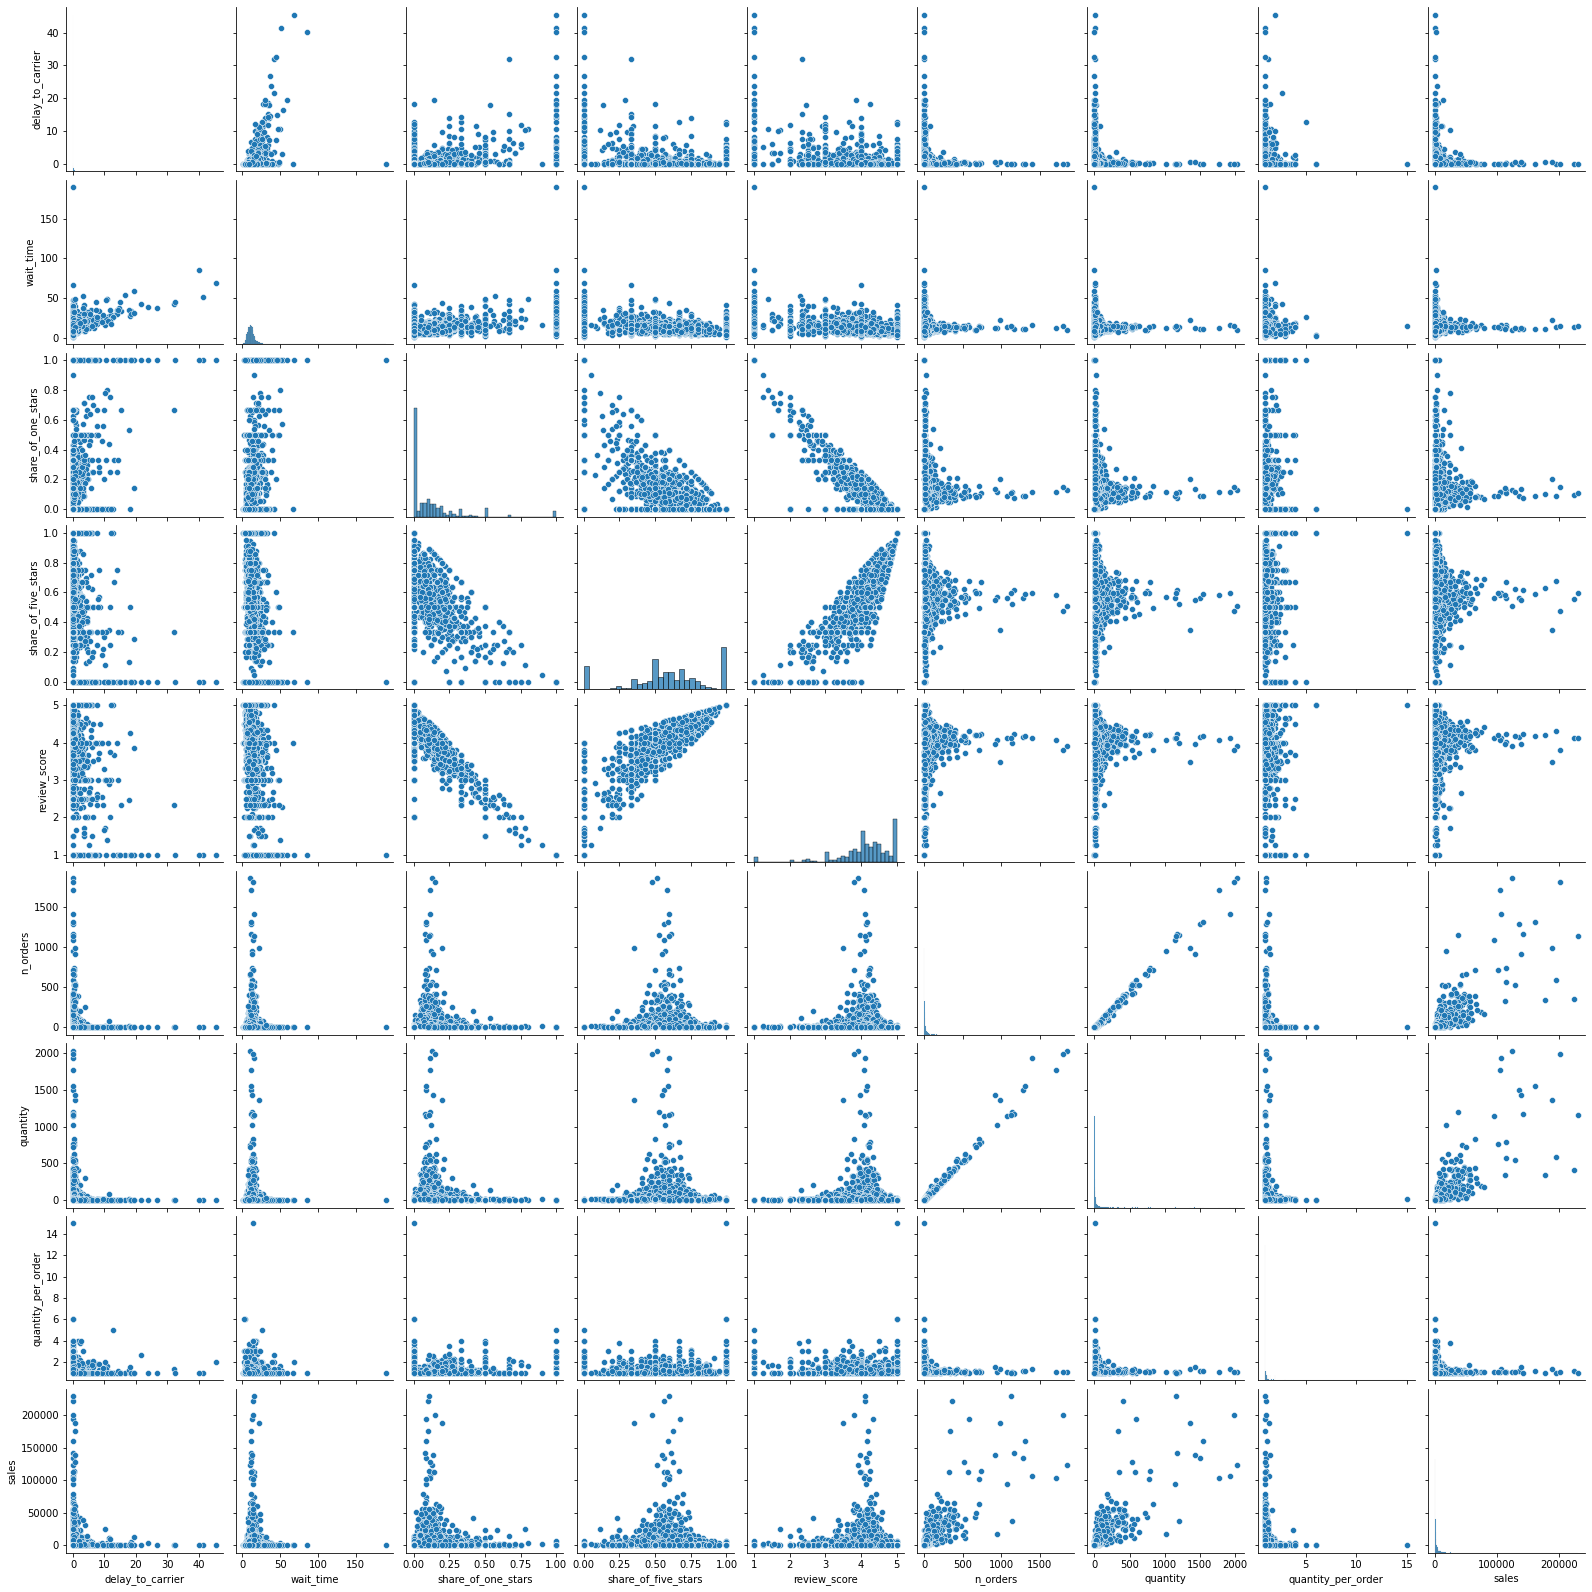

In [4]:
sns.pairplot(sellers)

----
💡There seems to be a group of sellers which stands out for having very low review scores! Let's investigate graphically:

❓ Using plotly, create a scatterplot of `delay_to_carrier` against `wait_time`, varying bubble size by total `sales` for that seller, and coloring by `review_score`. 

In [ ]:
import plotly.express as px

Feel free to change values `x`, `y`, `color` and `size` to try identify who are the worst sellers

### 2.2 - Model out `review_score` with OLS

❓ Scatter plots have their limits. A more rigorous way to explain sellers' review_score is to **model out the impact of various features on `review_score` with a multivariate-OLS in statsmodels.** 

Create an OLS with only the numerical features of your choice. What are the most impactful ones? Don't forget to standardize your features using our function below if you want to compare the regression coefficients together.

In [ ]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [ ]:
# Your code

❓ Finally, investigate your model's performance (r-squared) and residuals

In [ ]:
# Your code

### 2.3 - Add seller_state to your analysis

❓ We haven't used information about `seller_state` yet.  
- Create a new OLS model regressing `review_score` on `seller_states` only.
- Analyse your significant features using `return_significative_coef(model)` coded for you in `olist/utils.py`
- What are the best states in terms of `review_score`? 

<details>
    <summary>Hints</summary>
        
Be careful, seller_state is a categorical feature. Use `C(a_cat_feature)` in the formula to indicate categorical variables. It will create one boolean variable `is_cat_feature_xx` **per unique category** 

</details>

In [ ]:
# Your code

☝️ Some states indeed have _signigicantly_ better reviews than others on average. Is it due to some lower `quantity_per_order`, lower `wait_time`, or `delay_to_carrier`? Or is it due to some other factors that we haven't collected data about?

❓ Try to isolate the impact of the `seller_state` from the rest by adding other continuous features to your OLS until seller_states is no longer statistically siginificant.

In [ ]:
# Your code

☝️ After adding `wait_time` to our analysis, none of the 22 dummy variables `is_seller_state_xx` are statistically signigicant:

Given our small dataset (most states have very few sellers):
- We _cannot conclude_ that "some states are inherently better than other for reasons that would be independent of the `wait_time`" 
- In other words, we _cannot reject the hypothesis_ that "seller_state has no impact on review_score, other than through `wait_time`"

🏁 **Congratulations! Commit and push your notebook as well as `seller.py`**